# The data block API

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.vision import * 
from fastai import *
np.random.seed(42)

The data block API lets you customize how to create a [`DataBunch`](/basic_data.html#DataBunch) by isolating the underlying parts of that process in separate blocks, mainly:
  1. Where are the inputs and how to create them?
  1. How to split the data into a training and validation set?
  1. How to label the inputs?
  1. What transforms to apply?
  1. How to add a test set?
  1. How to wrap in dataloaders and create the [`DataBunch`](/basic_data.html#DataBunch)?
  
For each of those questions, you can have multiple possible blocks: your inputs might be in a folder, a csv file, a dataframe. You may want to split them randomly, by certain indexes or depending on the folder they are in. You can have your labels in your csv file or your dataframe, but it may come from folders or a specific function of the input. You may or may not have data augmentation to deal with. Or a test set. Finally you have to set the arguments to put the data together in a [`DataBunch`](/basic_data.html#DataBunch) (batch size, collate function...)

The data block API is called as such because you can mix and match each one of those blocks with the others, allowing you total flexibility to create your customized [`DataBunch`](/basic_data.html#DataBunch) for training. The factory methods of the various [`DataBunch`](/basic_data.html#DataBunch) are great for beginners but you can't always make your data fit in the tracks they require.

<img src="imgs/mix_match.png" alt="Mix and match" width="200">

As usual, we'll begin with end-to-end examples, then switch to the details of each of those parts.

## Examples of use

Let's begin by our traditional MNIST example.

In [ ]:
path = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False)
path.ls()

[PosixPath('/home/jhoward/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/home/jhoward/.fastai/data/mnist_tiny/valid'),
 PosixPath('/home/jhoward/.fastai/data/mnist_tiny/models'),
 PosixPath('/home/jhoward/.fastai/data/mnist_tiny/train'),
 PosixPath('/home/jhoward/.fastai/data/mnist_tiny/test'),
 PosixPath('/home/jhoward/.fastai/data/mnist_tiny/labels.csv')]

In [ ]:
(path/'train').ls()

[PosixPath('/home/jhoward/.fastai/data/mnist_tiny/train/3'),
 PosixPath('/home/jhoward/.fastai/data/mnist_tiny/train/7')]

In [`vision.data`](/vision.data.html#vision.data), we create an easy [`DataBunch`](/basic_data.html#DataBunch) suitable for classification by simply typing:

In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=24)

This is aimed at data that is in folders following an ImageNet style, with a train and valid directory containing each one subdirectory per class, where all the pictures are. There is also a test set containing unlabelled pictures. With the data block API, we can group everything together like this:

In [ ]:
data = (ImageItemList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

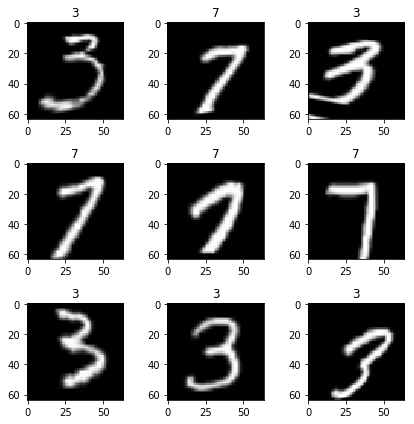

In [ ]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [ ]:
data.train_ds[0], data.test_ds.classes

((Image (3, 64, 64), Category 7), ['7', '3'])

Let's look at another example from [`vision.data`](/vision.data.html#vision.data) with the planet dataset. This time, it's a multiclassification problem with the labels in a csv file and no given split between valid and train data, so we use a random split. The factory method is:

In [ ]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
data = ImageDataBunch.from_csv(planet, folder='train', size=128, suffix='.jpg', sep = ' ', ds_tfms=planet_tfms)

With the data block API we can rewrite this like that:

In [ ]:
data = (ImageItemList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        #Where to find the data? -> in planet 'train' folder
        .random_split_by_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(sep=' ')
        #How to label? -> use the csv file
        .transform(planet_tfms, size=128)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())                          
        #Finally -> use the defaults for conversion to databunch

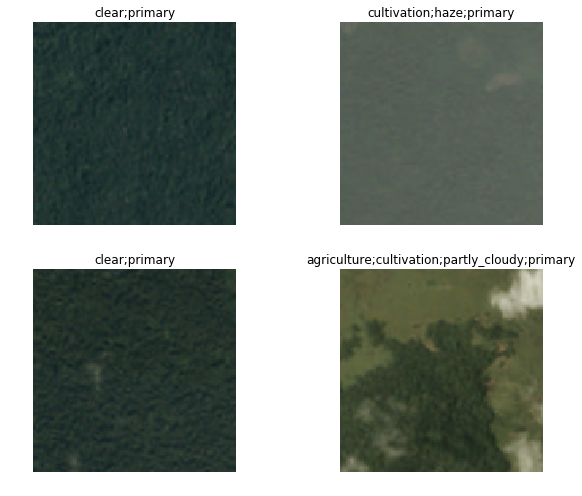

In [ ]:
data.show_batch(rows=2, figsize=(9,7))

The data block API also allows you to get your data together in problems for which there is no direct [`ImageDataBunch`](/vision.data.html#ImageDataBunch) factory method. For a segmentation task, for instance, we can use it to quickly get a [`DataBunch`](/basic_data.html#DataBunch). Let's take the example of the [camvid dataset](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/). The images are in an 'images' folder and their corresponding mask is in a 'labels' folder.

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

We have a file that gives us the names of the classes (what each code inside the masks corresponds to: a pedestrian, a tree, a road...)

In [ ]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

And we define the following function that infers the mask filename from the image filename.

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

Then we can easily define a [`DataBunch`](/basic_data.html#DataBunch) using the data block API. Here we need to use `tfm_y=True` in the transform call because we need the same transforms to be applied to the target mask as were applied to the image.

In [ ]:
data = (SegmentationItemList.from_folder(path_img)
        .random_split_by_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=128)
        .databunch())

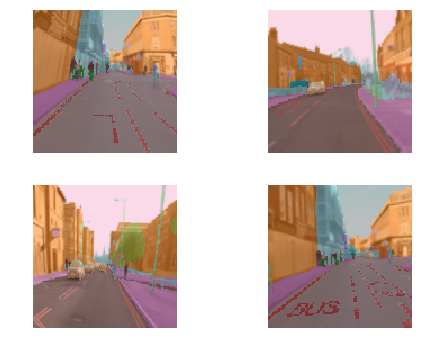

In [ ]:
data.show_batch(rows=2, figsize=(7,5))

Another example for object detection. We use our tiny sample of the [COCO dataset](http://cocodataset.org/#home) here. There is a helper function in the library that reads the annotation file and returns the list of images names with the list of labelled bboxes associated to it. We convert it to a dictionary that maps image names with their bboxes and then write the function that will give us the target for each image filename.

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

The following code is very similar to what we saw before. The only new addition is the use of special function to collate the samples in batches. This comes from the fact that our images may have multiple bounding boxes, so we need to pad them to the largest number of bounding boxes.

In [ ]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco
        .random_split_by_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=16, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch and we use bb_pad_collate

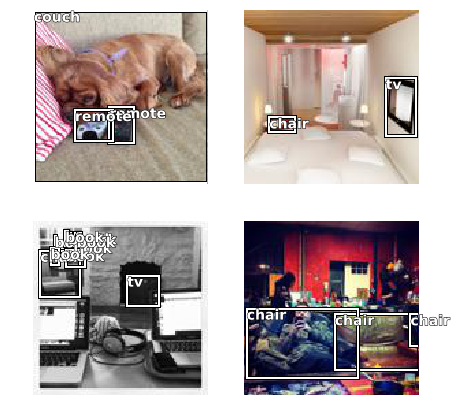

In [ ]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(6,6))

But vision isn't the only application where the data block API works, it can also be used for text or tabular data. With ouy sample of the IMDB dataset (labelled texts in a csv file), here is how to get the data together for a language model.

In [ ]:
from fastai.text import *

In [ ]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [ ]:
data_lm = (TextList.from_csv(imdb, 'texts.csv', cols='text')
           #Where are the inputs? Column 'text' of this csv
                   .random_split_by_pct()
           #How to split it? Randomly with the default 20%
                   .label_for_lm()
           #Label it for a language model
                   .databunch())

In [ ]:
data_lm.show_batch()

idx,text
0,"xxfld 1 old jane 's mannered tale seems very popular these days . i have lost count of the number of versions going around . probably the reason is that her "" xxunk "" are our "" xxunk "" even at this late date . this tv mini - series gives it a mannered telling suitable to the novel . xxunk , xxunk emma is a pretty "" modern "" girl when you think about it , even though the xxunk of jane austen 's world may seem a xxunk artificial to us today ."
1,"country - road music score from xxunk jones , amazing performances in two principal roles from robert blake and scott wilson and first time in a movie a sad comment about xxunk punishment at the last moments before their deaths . jones , hall and brooks ( as director and as writer for adapted screenplay ) are academy award xxunk . gripping , superbly directed and frightening , one of the best films of this decade xxfld 1 there were a lot of truly great horror movies produced in the seventies - but this film"
2,"sister xxunk , who pretty much steals the show . with absolutely beautiful xxunk , she sings several songs throughout the film , though i actually would have liked to have seen them feature her even more in this . the plot in this film is a bit silly , but nevertheless , i found the film to be entertaining and fun . xxfld 1 there 's something compelling and strangely believable about this episode . from the very beginning , an atmosphere of tension is created by the knowledge that a certain planet is"
3,""" xxunk "" plot , this one has a xxunk mess of a story , with too many dull characters xxunk each other in the back so many times the potential for any sympathy or xxunk is xxunk . gone is the effective xxunk between the lead characters ; azumi and her xxunk are often reduced to a bunch of xxunk teenagers xxunk in a forest . xxunk is non existent ; if anyone watching actually cares who lives and who dies , i 'll be shocked . the same xxunk to the villains here"
4,"gary cooper as wild bill xxunk , with jean arthur as xxunk jane . james xxunk was buffalo bill , john xxunk ( not a villain as usual ) was general george a. xxunk , and anthony quinn was one of the indians who fought at little big xxunk . the villains were led by charles xxunk ( xxunk arms to the indians ) and porter hall as jack xxunk ( who killed wild bill xxunk ) . \n\n basically the film takes up the history of the u.s . after the civil war ."
5,"xxunk . where it all comes xxunk is in the script , which did n't do any better when it was called missing in action and starred xxunk xxunk . what little semblance of logic there was in the original is now gone , as the filmmakers decide to paint a big s on rambo 's massive chest . \n\n the film picks up a little while after the end of first blood . the film , that is - the novel did n't allow for the possibility of sequels . in this mediocre follow"
6,"the xxunk and the xxunk ' ( xxunk ) , ' 28 days later ' ( 2002 ) and its sequel , as well as many , many , others too numerous to mention . \n\n this one is not really a zombie film . judging this movie on its own terms , it 's more of a semi - gothic romance . as such it ranks a little below some of universal 's bottom billed b horror movies of the late 30s and early xxunk . so i 'll give it a 5 ."
7,"of xxup the xxup demon ) \n\n * spoiler * \n\n this was a drive - in feature , co - billed with xxup the xxup xxunk xxup vampire . a spanish - italian co - production where a series of women in a village are being murdered around the same time a local count named yanos xxunk is seen on xxunk , riding off with his ' man - eating ' dog behind him . \n\n the xxunk already suspect he is the one behind it all and want his castle burned down ."
8,"the visual than in the message . \n\n thus , you will find some funny scenes ( the first xxunk of the town , a "" xxunk "" xxunk xxunk ) and the casting is xxunk , with special mentions to "" doc "" , who xxunk in a "" xxunk fly "" character , and to xxunk , who seems o

For a classification problem, we just have to change the way labelling is done. Here we use the column 'label' of our csv.

In [ ]:
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text')
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch())

In [ ]:
data_clas.show_batch()

text,label
"xxfld 1 raising victor vargas : a review \n\n you know , raising victor vargas is like sticking your hands into a big , xxunk bowl of xxunk . it 's warm and gooey , but you 're not sure if it feels right . try as i might ,",negative
"xxfld 1 xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words",positive
"xxfld 1 now that che(2008 ) has finished its relatively short australian cinema run ( extremely limited xxunk screen in xxunk , after xxunk ) , i can xxunk join both xxunk of "" at the movies "" in taking steven soderbergh to task . \n\n it 's usually satisfying",negative
"xxfld 1 many neglect that this is n't just a classic due to the fact that it 's the first 3d game , or even the first xxunk - up . it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly",positive
"xxfld 1 i really wanted to love this show . i truly , honestly did . \n\n for the first time , gay viewers get their own version of the "" the bachelor "" . with the help of his obligatory "" hag "" xxunk , james , a good",negative


In [ ]:
from fastai.tabular import *

Lastly, for tabular data, we just have to pass the name of our categorical and continuous variables as an extra argument. We also add [`PreProcessor`](/data_block.html#PreProcessor) that are going to be applied to our data once the splitting and the labelling is done.

In [ ]:
adult = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult/'adult.csv')
dep_var = '>=50k'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont_names = ['education-num', 'hours-per-week', 'age', 'capital-loss', 'fnlwgt', 'capital-gain']
procs = [FillMissing, Categorify, Normalize]

In [ ]:
data = (TabularList.from_df(df, path=adult, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=range(800,1000))
                           .label_from_df(cols=dep_var)
                           .databunch())

In [ ]:
data.show_batch()

workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,education-num,hours-per-week,age,capital-loss,fnlwgt,capital-gain,target
Self-emp-inc,HS-grad,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,False,-0.4224,2.3943,0.5434,-0.2164,-0.6319,-0.1459,0
Local-gov,Masters,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,False,1.5334,-0.0356,1.5695,-0.2164,-0.4559,-0.1459,1
Private,10th,Separated,Other-service,Own-child,Black,Female,United-States,False,-1.5958,-2.3036,0.0303,-0.2164,1.2202,-0.1459,0
Private,Bachelors,Never-married,Exec-managerial,Not-in-family,White,Male,United-States,False,1.1422,-0.0356,-1.0692,-0.2164,-0.4714,-0.1459,0
Private,Bachelors,Never-married,Machine-op-inspct,Not-in-family,White,Female,United-States,False,1.1422,-0.1166,-0.3362,-0.2164,2.3204,-0.1459,0
Local-gov,Assoc-voc,Never-married,Other-service,Unmarried,Black,Female,United-States,False,0.3599,-0.6836,-0.1163,-0.2164,0.3157,-0.1459,0
Federal-gov,HS-grad,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,False,-0.4224,-0.0356,0.3968,-0.2164,-0.0533,-0.1459,1
Private,11th,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,False,-1.2046,-0.0356,0.8365,-0.2164,0.7282,-0.1459,0


## Step 1: Provide inputs

The basic class to get your inputs into is the following one. It's also the same class that will contain all of your labels (hence the name [`ItemList`](/data_block.html#ItemList)).

In [ ]:
show_doc(ItemList, title_level=3, doc_string=False)

<h3 id="ItemList"><code>class</code> <code>ItemList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L23" class="source_link">[source]</a></h3>

> <code>ItemList</code>(`items`:`Iterator`, `create_func`:`Callable`=`None`, `path`:`PathOrStr`=`'.'`, `label_cls`:`Callable`=`None`, `xtra`:`Any`=`None`, `processor`:[`PreProcessor`](/data_block.html#PreProcessor)=`None`, `kwargs`)

This class regroups the inputs for our model in `items` and saves a `path` attribute which is where it will look for any files (image files, csv file with labels...) `create_func` is applied to `items` to get the final output. `label_cls` will be called to create the labels from the result of the label function, `xtra` contains additional information (usually an underlying dataframe) and `processor` is to be applied to the inputs after the splitting and labelling.

It has multiple subclasses depending on the type of data you're handling. Here is a quick list:
  - [`CategoryList`](/data_block.html#CategoryList) for labels in classification
  - [`MultiCategoryList`](/data_block.html#MultiCategoryList) for labels in a multi classification problem
  - [`FloatList`](/data_block.html#FloatList) for float labels in a regression problem
  - [`ImageItemList`](/vision.data.html#ImageItemList) for data that are images
  - [`SegmentationItemList`](/vision.data.html#SegmentationItemList) like [`ImageItemList`](/vision.data.html#ImageItemList) but will default labels to [`SegmentationLabelList`](/vision.data.html#SegmentationLabelList)
  - [`SegmentationLabelList`](/vision.data.html#SegmentationLabelList) for segmentation masks
  - [`ObjectItemList`](/vision.data.html#ObjectItemList) like [`ImageItemList`](/vision.data.html#ImageItemList) but will default labels to `ObjectLabelList`
  - `ObjectLabelList` for object detection
  - [`PointsItemList`](/vision.data.html#PointsItemList) for points (of the type [`ImagePoints`](/vision.image.html#ImagePoints))
  - [`TextList`](/text.data.html#TextList) for text data
  - [`TextFilesList`](/text.data.html#TextFilesList) for text data stored in files
  - [`TabularList`](/tabular.data.html#TabularList) for tabular data

Once you have selected the class that is suitable, you can instantiate it with one of the following factory methods

In [ ]:
show_doc(ItemList.from_folder)

<h4 id="ItemList.from_folder"><code>from_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L67" class="source_link">[source]</a></h4>

> <code>from_folder</code>(`path`:`PathOrStr`, `extensions`:`StrList`=`None`, `recurse`=`True`, `kwargs`) → `ItemList`

Get the list of files in `path` that have a suffix in `extensions`. `recurse` determines if we search subfolders.  

In [ ]:
show_doc(ItemList.from_df)

<h4 id="ItemList.from_df"><code>from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L72" class="source_link">[source]</a></h4>

> <code>from_df</code>(`df`:`DataFrame`, `path`:`PathOrStr`=`'.'`, `cols`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`0`, `kwargs`) → `ItemList`

Create an [`ItemList`](/data_block.html#ItemList) in `path` from the inputs in the `cols` of `df`.  

In [ ]:
show_doc(ItemList.from_csv)

<h4 id="ItemList.from_csv"><code>from_csv</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L79" class="source_link">[source]</a></h4>

> <code>from_csv</code>(`path`:`PathOrStr`, `csv_name`:`str`, `cols`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`0`, `header`:`str`=`'infer'`, `kwargs`) → `ItemList`

Create an [`ItemList`](/data_block.html#ItemList) in `path` from the inputs in the `cols` of `path/csv_name` opened with `header`.  

### Optional step: filter your data

The factory method may have grabbed too many items. For instance, if you were searching sub folders with the `from_folder` method, you may have gotten files you don't want. To remove those, you can use one of the following methods.

In [ ]:
show_doc(ItemList.filter_by_func)

<h4 id="ItemList.filter_by_func"><code>filter_by_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L85" class="source_link">[source]</a></h4>

> <code>filter_by_func</code>(`func`:`Callable`) → `ItemList`

Only keeps elements for which `func` returns `True`.  

In [ ]:
show_doc(ItemList.filter_by_folder)

<h4 id="ItemList.filter_by_folder"><code>filter_by_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L90" class="source_link">[source]</a></h4>

> <code>filter_by_folder</code>(`include`=`None`, `exclude`=`None`)

Only keep filenames in `include` folder or reject the ones in `exclude`.  

### Writing your own [`ItemList`](/data_block.html#ItemList)

First check if you can't easily customize one of the existing subclass by:
- changing the `create_func` (example: opening images with your custom function and not [`open_image`](/vision.image.html#open_image))
- applying a custom `processor` (see step 4)
- changing the default `label_cls` for the label creation.

If this isn't the case and you really need to write your own class, here is what you should code:

```
class MyCustomItemList():
    #If you need custom arguments you will have to overwrite __init__ and new like this.
    def __init__(self, items:Iterator, my_args, **kwargs):
        super().__init__(items, **kwargs)
        #store my args, initialize what is needed.

    def new(self, items:Iterator, **kwargs)->'NumericalizedTextList':
        #Retrive your custom args stored and send them to new like this
        return super().new(items=items,  my_args, **kwargs)

    #This is how to get your data stored at index i
    def get(self, i):
        o = super().get(i)
        return what you need from o
```

You can add custom splitting or labelling methods if you need them.

In [ ]:
show_doc(ItemList.predict)

<h4 id="ItemList.predict"><code>predict</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L54" class="source_link">[source]</a></h4>

> <code>predict</code>(`res`)

Called at the end of `Learn.predict`; override for optional post-processing  

## Step 2: Split the data between the training and the validation set

This step is normally straightforward, you just have to pick oe of the following functions depending on what you need.

In [ ]:
show_doc(ItemList.random_split_by_pct)

<h4 id="ItemList.random_split_by_pct"><code>random_split_by_pct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L122" class="source_link">[source]</a></h4>

> <code>random_split_by_pct</code>(`valid_pct`:`float`=`0.2`, `seed`:`int`=`None`) → `ItemLists`

Split the items randomly by putting `valid_pct` in the validation set. Set the `seed` in numpy if passed.  

In [ ]:
show_doc(ItemList.split_by_files)

<h4 id="ItemList.split_by_files"><code>split_by_files</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L134" class="source_link">[source]</a></h4>

> <code>split_by_files</code>(`valid_names`:`ItemList`) → `ItemLists`

Split the data by using the names in `valid_names` for validation.  

In [ ]:
show_doc(ItemList.split_by_fname_file)

<h4 id="ItemList.split_by_fname_file"><code>split_by_fname_file</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L139" class="source_link">[source]</a></h4>

> <code>split_by_fname_file</code>(`fname`:`PathOrStr`, `path`:`PathOrStr`=`None`) → `ItemLists`

Split the data by using the file names in `fname` for the validation set. `path` will override `self.path`.  

In [ ]:
show_doc(ItemList.split_by_folder)

<h4 id="ItemList.split_by_folder"><code>split_by_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L118" class="source_link">[source]</a></h4>

> <code>split_by_folder</code>(`train`:`str`=`'train'`, `valid`:`str`=`'valid'`) → `ItemLists`

Split the data depending on the folder (`train` or `valid`) in which the filenames are.  

In [ ]:
jekyll_note("This method looks at the folder immediately after `self.path` for `valid` and `train`.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method looks at the folder immediately after `self.path` for `valid` and `train`.</div>

In [ ]:
show_doc(ItemList.split_by_idx)

<h4 id="ItemList.split_by_idx"><code>split_by_idx</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L108" class="source_link">[source]</a></h4>

> <code>split_by_idx</code>(`valid_idx`:`Collection`\[`int`\]) → `ItemLists`

Split the data according to the indexes in `valid_idx`.  

In [ ]:
show_doc(ItemList.split_by_idxs)

<h4 id="ItemList.split_by_idxs"><code>split_by_idxs</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L104" class="source_link">[source]</a></h4>

> <code>split_by_idxs</code>(`train_idx`, `valid_idx`)

Split the data between `train_idx` and `valid_idx`.  

In [ ]:
show_doc(ItemList.split_by_list)

<h4 id="ItemList.split_by_list"><code>split_by_list</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L100" class="source_link">[source]</a></h4>

> <code>split_by_list</code>(`train`, `valid`)

Split the data between `train` and `valid`.  

In [ ]:
show_doc(ItemList.split_by_valid_func)

<h4 id="ItemList.split_by_valid_func"><code>split_by_valid_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L129" class="source_link">[source]</a></h4>

> <code>split_by_valid_func</code>(`func`:`Callable`) → `ItemLists`

Split the data by result of `func` (which returns `True` for validation set)  

In [ ]:
show_doc(ItemList.split_from_df)

<h4 id="ItemList.split_from_df"><code>split_from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L145" class="source_link">[source]</a></h4>

> <code>split_from_df</code>(`col`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`2`)

Split the data from the `col` in the dataframe in `self.xtra`.  

In [ ]:
jekyll_warn("This method assumes the data has been created from a csv file or a dataframe.")

<div markdown="span" class="alert alert-danger" role="alert"><i class="fa fa-danger-circle"></i> <b>Warning: </b>This method assumes the data has been created from a csv file or a dataframe.</div>

## Step 3: Label the inputs

To label your inputs, use one of the following functions. Note that even if it's not in the documented arguments, you can always pass a `label_cls` that will be used to create those labels (the default is the one from your input [`ItemList`](/data_block.html#ItemList), and if there is none, it will go to [`CategoryList`](/data_block.html#CategoryList),  [`MultiCategoryList`](/data_block.html#MultiCategoryList) or [`FloatList`](/data_block.html#FloatList) depending on the type of the labels).

In [ ]:
show_doc(ItemList.label_from_list)

<h4 id="ItemList.label_from_list"><code>label_from_list</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L160" class="source_link">[source]</a></h4>

> <code>label_from_list</code>(`labels`:`Iterator`, `kwargs`) → `LabelList`

Label `self.items` with `labels` using `label_cls`  

In [ ]:
show_doc(ItemList.label_from_df)

<h4 id="ItemList.label_from_df"><code>label_from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L168" class="source_link">[source]</a></h4>

> <code>label_from_df</code>(`cols`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`1`, `kwargs`)

Label `self.items` from the values in `cols` in `self.xtra`.  

In [ ]:
jekyll_warn("This method assumes the data has been created from a csv file or a dataframe.")

<div markdown="span" class="alert alert-danger" role="alert"><i class="fa fa-danger-circle"></i> <b>Warning: </b>This method assumes the data has been created from a csv file or a dataframe.</div>

In [ ]:
show_doc(ItemList.label_const)

<h4 id="ItemList.label_const"><code>label_const</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L173" class="source_link">[source]</a></h4>

> <code>label_const</code>(`const`:`Any`=`0`, `kwargs`) → `LabelList`

Label every item with `const`.  

In [ ]:
show_doc(ItemList.label_from_folder)

<h4 id="ItemList.label_from_folder"><code>label_from_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L181" class="source_link">[source]</a></h4>

> <code>label_from_folder</code>(`kwargs`) → `LabelList`

Give a label to each filename depending on its folder.  

In [ ]:
jekyll_note("This method looks at the last subfolder in the path to determine the classes.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method looks at the last subfolder in the path to determine the classes.</div>

In [ ]:
show_doc(ItemList.label_from_func)

<h4 id="ItemList.label_from_func"><code>label_from_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L177" class="source_link">[source]</a></h4>

> <code>label_from_func</code>(`func`:`Callable`, `kwargs`) → `LabelList`

Apply `func` to every input to get its label.  

In [ ]:
show_doc(ItemList.label_from_re)

<h4 id="ItemList.label_from_re"><code>label_from_re</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L185" class="source_link">[source]</a></h4>

> <code>label_from_re</code>(`pat`:`str`, `full_path`:`bool`=`False`, `kwargs`) → `LabelList`

Apply the re in `pat` to determine the label of every filename.  If `full_path`, search in the full name.  

In [ ]:
show_doc(CategoryList, title_level=3)

<h3 id="CategoryList"><code>class</code> <code>CategoryList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L222" class="source_link">[source]</a></h3>

> <code>CategoryList</code>(`items`:`Iterator`, `classes`:`Collection`=`None`, `processor`:[`PreProcessor`](/data_block.html#PreProcessor)=`None`, `kwargs`) :: [`CategoryListBase`](/data_block.html#CategoryListBase)

[`ItemList`](/data_block.html#ItemList) suitable for storing labels in `items` belonging to `classes`. If `None` are passed, `classes` will be determined by the unique different labels. `processor` will default to [`CategoryProcessor`](/data_block.html#CategoryProcessor).

In [ ]:
show_doc(MultiCategoryList, title_level=3)

<h3 id="MultiCategoryList"><code>class</code> <code>MultiCategoryList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L245" class="source_link">[source]</a></h3>

> <code>MultiCategoryList</code>(`items`:`Iterator`, `classes`:`Collection`=`None`, `processor`:[`PreProcessor`](/data_block.html#PreProcessor)=`None`, `sep`:`str`=`None`, `kwargs`) :: [`CategoryListBase`](/data_block.html#CategoryListBase)

[`ItemList`](/data_block.html#ItemList) suitable for storing list of labels in `items` belonging to `classes`. If `None` are passed, `classes` will be determined by the unique different labels. `sep` is used to split the content of `items` in a list of labels.

In [ ]:
show_doc(FloatList, title_level=3)

<h3 id="FloatList"><code>class</code> <code>FloatList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L257" class="source_link">[source]</a></h3>

> <code>FloatList</code>(`items`:`Iterator`, `log`:`bool`=`False`, `kwargs`) :: [`ItemList`](/data_block.html#ItemList)

[`ItemList`](/data_block.html#ItemList) suitable for storing the floats in items for regression. Will add a `log` if this flag is `True`.

## Invisible step: preprocessing

This isn't seen tehre in the API, but if you passed a `processor` (or a list of them) in your initial [`ItemList`](/data_block.html#ItemList) during step 1, it will be applied here. A processor is a transformation that is applied to all the inputs once and for all, with a state computed on the training set that is then applied without modification on the validation set (and maybe the test set). For instance, it can be processing texts to tokenize then numericalize them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in tabular data, where we fill missing values with (for instance) the median computed on the training set. That statistic is stored in the inner state of the [`PreProcessor`](/data_block.html#PreProcessor) and applied on the validation set.

This is the generic class for all processors.

In [ ]:
show_doc(PreProcessor, title_level=3)

<h3 id="PreProcessor"><code>class</code> <code>PreProcessor</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L19" class="source_link">[source]</a></h3>

> <code>PreProcessor</code>()

In [ ]:
show_doc(PreProcessor.process_one)

<h4 id="PreProcessor.process_one"><code>process_one</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L20" class="source_link">[source]</a></h4>

> <code>process_one</code>(`item`)

Process one `item`. This method needs to be written in any subclass.

In [ ]:
show_doc(PreProcessor.process)

<h4 id="PreProcessor.process"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L21" class="source_link">[source]</a></h4>

> <code>process</code>(`ds`:`Collection`)

Process a dataset. This default to apply `process_one` on every `item` of `ds`.

In [ ]:
show_doc(CategoryProcessor, title_level=3)

<h3 id="CategoryProcessor"><code>class</code> <code>CategoryProcessor</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L195" class="source_link">[source]</a></h3>

> <code>CategoryProcessor</code>(`classes`:`Collection`=`None`) :: [`PreProcessor`](/data_block.html#PreProcessor)

[`PreProcessor`](/data_block.html#PreProcessor) that will convert labels to codes usings `classes` (if passed) in a single classificatio problem.

In [ ]:
show_doc(MultiCategoryProcessor, title_level=3)

<h3 id="MultiCategoryProcessor"><code>class</code> <code>MultiCategoryProcessor</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L237" class="source_link">[source]</a></h3>

> <code>MultiCategoryProcessor</code>(`classes`:`Collection`=`None`) :: [`CategoryProcessor`](/data_block.html#CategoryProcessor)

[`PreProcessor`](/data_block.html#PreProcessor) that will convert labels to codes usings `classes` (if passed) in a single multi-classificatio problem.

## Optional steps

### Add transforms

Transforms differ from processors in the sense they are applied on the fly when we grab one item. They also may change each time we ask for the same item in the case of random transforms.

In [ ]:
show_doc(LabelLists.transform)

<h4 id="ItemLists.transform"><code>transform</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L310" class="source_link">[source]</a></h4>

> <code>transform</code>(`tfms`:`Optional`\[`Tuple`\[`Union`\[`Callable`, `Collection`\[`Callable`\]\], `Union`\[`Callable`, `Collection`\[`Callable`\]\]\]\]=`(None, None)`, `kwargs`)

Set `tfms` to be applied to the train and validation set.  

This is primary for the vision application. The `kwargs` are the one expected by the type of transforms you pass. `tfm_y` is among them and if set to `True`, the transforms will be applied to input and target.

### Add a test set

To add a test set, you can use one of the two following methods.

In [ ]:
show_doc(LabelLists.add_test)

<h4 id="LabelLists.add_test"><code>add_test</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L334" class="source_link">[source]</a></h4>

> <code>add_test</code>(`items`:`Iterator`, `label`:`Any`=`None`)

Add test set containing items from `items` and an arbitrary `label`  

In [ ]:
jekyll_note("Here `items` can be an `ItemList` or a collection.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>Here `items` can be an `ItemList` or a collection.</div>

In [ ]:
show_doc(LabelLists.add_test_folder)

<h4 id="LabelLists.add_test_folder"><code>add_test_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L343" class="source_link">[source]</a></h4>

> <code>add_test_folder</code>(`test_folder`:`str`=`'test'`, `label`:`Any`=`None`)

Add test set containing items from folder `test_folder` and an arbitrary `label`.  

## Step 4: convert to a [`DataBunch`](/basic_data.html#DataBunch)

This last step is usually pretty straightforward. You just have to include all the arguments we pass to [`DataBunch.create`](/basic_data.html#DataBunch.create) (`bs`, `num_workers`,  `collate_fn`). The class called to create a [`DataBunch`](/basic_data.html#DataBunch) is set in the `_bunch` attribute of the inputs of the training set if you need to modify it. Normally, the various subclasses we showed before handle that for you.

In [ ]:
show_doc(LabelLists.databunch)

<h4 id="LabelLists.databunch"><code>databunch</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L329" class="source_link">[source]</a></h4>

> <code>databunch</code>(`path`:`PathOrStr`=`None`, `kwargs`) → `ImageDataBunch`

Create an [`DataBunch`](/basic_data.html#DataBunch) from self, `path` will override `self.path`, `kwargs` are passed to [`DataBunch.create`](/basic_data.html#DataBunch.create).  

## Inner classes

In [ ]:
show_doc(LabelList, title_level=3, doc_string=False)

<h3 id="LabelList"><code>class</code> <code>LabelList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L348" class="source_link">[source]</a></h3>

> <code>LabelList</code>(`x`:[`ItemList`](/data_block.html#ItemList), `y`:[`ItemList`](/data_block.html#ItemList), `tfms`:`Union`\[`Callable`, `Collection`\[`Callable`\]\]=`None`, `tfm_y`:`bool`=`False`, `kwargs`) :: [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

The basic dataset in fastai. Inputs are in `x`, targets in `y`. Optionally apply `tfms` to `x` and also `y` if `tfm_y` is `True`. 

In [ ]:
show_doc(LabelList.from_lists)

<h4 id="LabelList.from_lists"><code>from_lists</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L396" class="source_link">[source]</a></h4>

> <code>from_lists</code>(`path`:`PathOrStr`, `inputs`, `labels`) → `LabelList`

Create a [`LabelList`](/data_block.html#LabelList) in `path` with `inputs` and `labels`.  

In [ ]:
show_doc(ItemLists, doc_string=False, title_level=3)

<h3 id="ItemLists"><code>class</code> <code>ItemLists</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L272" class="source_link">[source]</a></h3>

> <code>ItemLists</code>(`path`:`PathOrStr`, `train`:[`ItemList`](/data_block.html#ItemList), `valid`:[`ItemList`](/data_block.html#ItemList), `test`:[`ItemList`](/data_block.html#ItemList)=`None`)

Data in `path` split between several streams of inputs, [`train`](/train.html#train), `valid` and maybe `test`.

In [ ]:
show_doc(ItemLists.label_from_lists)

<h4 id="ItemLists.label_from_lists"><code>label_from_lists</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L301" class="source_link">[source]</a></h4>

> <code>label_from_lists</code>(`train_labels`:`Iterator`, `valid_labels`:`Iterator`, `label_cls`:`Callable`=`None`, `kwargs`) → `LabelList`

Use the labels in `train_labels` and `valid_labels` to label the data. `label_cls` will overwrite the default.  

In [ ]:
show_doc(LabelLists, title_level=3, doc_string=False)

<h3 id="LabelLists"><code>class</code> <code>LabelLists</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L318" class="source_link">[source]</a></h3>

> <code>LabelLists</code>(`path`:`PathOrStr`, `train`:[`ItemList`](/data_block.html#ItemList), `valid`:[`ItemList`](/data_block.html#ItemList), `test`:[`ItemList`](/data_block.html#ItemList)=`None`) :: [`ItemLists`](/data_block.html#ItemLists)

## Helper functions

In [ ]:
show_doc(get_files)

<h4 id="get_files"><code>get_files</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L13" class="source_link">[source]</a></h4>

> <code>get_files</code>(`c`:`PathOrStr`, `extensions`:`StrList`=`None`, `recurse`:`bool`=`False`) → `FilePathList`

Return list of files in `c` that have a suffix in `extensions`. `recurse` determines if we search subfolders.  

## Undocumented Methods - Methods moved below this line will intentionally be hidden

In [ ]:
show_doc(ItemList.get)

<h4 id="ItemList.get"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L38" class="source_link">[source]</a></h4>

> <code>get</code>(`i`) → `Any`

In [ ]:
show_doc(CategoryList.new)

<h4 id="CategoryListBase.new"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L219" class="source_link">[source]</a></h4>

> <code>new</code>(`items`, `classes`=`None`, `kwargs`)

In [ ]:
show_doc(ItemList.label_cls)

<h4 id="ItemList.label_cls"><code>label_cls</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L150" class="source_link">[source]</a></h4>

> <code>label_cls</code>(`labels`, `label_cls`:`Callable`=`None`, `sep`:`str`=`None`, `kwargs`)

In [ ]:
show_doc(LabelLists.get_processors)

<h4 id="LabelLists.get_processors"><code>get_processors</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L319" class="source_link">[source]</a></h4>

> <code>get_processors</code>()

In [ ]:
show_doc(LabelList.from_lists)

<h4 id="LabelList.from_lists"><code>from_lists</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L396" class="source_link">[source]</a></h4>

> <code>from_lists</code>(`path`:`PathOrStr`, `inputs`, `labels`) → `LabelList`

Create a [`LabelList`](/data_block.html#LabelList) in `path` with `inputs` and `labels`.  

In [ ]:
show_doc(LabelList.set_item)

<h4 id="LabelList.set_item"><code>set_item</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L357" class="source_link">[source]</a></h4>

> <code>set_item</code>(`item`)

In [ ]:
show_doc(LabelList.new)

<h4 id="LabelList.new"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L365" class="source_link">[source]</a></h4>

> <code>new</code>(`x`, `y`, `kwargs`) → `LabelList`

In [ ]:
show_doc(CategoryList.get)

<h4 id="CategoryList.get"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L229" class="source_link">[source]</a></h4>

> <code>get</code>(`i`)

In [ ]:
show_doc(LabelList.predict)

<h4 id="LabelList.predict"><code>predict</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L360" class="source_link">[source]</a></h4>

> <code>predict</code>(`res`)

In [ ]:
show_doc(ItemList.new)

<h4 id="ItemList.new"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L58" class="source_link">[source]</a></h4>

> <code>new</code>(`items`:`Iterator`, `create_func`:`Callable`=`None`, `processor`:[`PreProcessor`](/data_block.html#PreProcessor)=`None`, `kwargs`) → `ItemList`

In [ ]:
show_doc(LabelList.clear_item)

<h4 id="LabelList.clear_item"><code>clear_item</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L358" class="source_link">[source]</a></h4>

> <code>clear_item</code>()

In [ ]:
show_doc(ItemList.process_one)

<h4 id="ItemList.process_one"><code>process_one</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L48" class="source_link">[source]</a></h4>

> <code>process_one</code>(`item`, `processor`=`None`)

In [ ]:
show_doc(ItemList.process)

<h4 id="ItemList.process"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L42" class="source_link">[source]</a></h4>

> <code>process</code>(`processor`=`None`)

In [ ]:
show_doc(LabelLists.process)

<h4 id="LabelLists.process"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L324" class="source_link">[source]</a></h4>

> <code>process</code>()

In [ ]:
show_doc(CategoryList.predict)

<h4 id="CategoryList.predict"><code>predict</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L233" class="source_link">[source]</a></h4>

> <code>predict</code>(`res`)

Called at the end of `Learn.predict`; override for optional post-processing  

In [ ]:
show_doc(ItemLists.transform)

<h4 id="ItemLists.transform"><code>transform</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L310" class="source_link">[source]</a></h4>

> <code>transform</code>(`tfms`:`Optional`\[`Tuple`\[`Union`\[`Callable`, `Collection`\[`Callable`\]\], `Union`\[`Callable`, `Collection`\[`Callable`\]\]\]\]=`(None, None)`, `kwargs`)

Set `tfms` to be applied to the train and validation set.  

In [ ]:
show_doc(LabelList.process)

<h4 id="LabelList.process"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L386" class="source_link">[source]</a></h4>

> <code>process</code>(`xp`=`None`, `yp`=`None`)

Launch the preprocessing on `xp` and `yp`.  

In [ ]:
show_doc(LabelList.transform)

<h4 id="LabelList.transform"><code>transform</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L402" class="source_link">[source]</a></h4>

> <code>transform</code>(`tfms`:`Union`\[`Callable`, `Collection`\[`Callable`\]\], `tfm_y`:`bool`=`None`, `kwargs`)

Set the `tfms` and `` tfm_y` value to be applied to the inputs and targets.  

## New Methods - Please document or move to the undocumented section

In [ ]:
show_doc(MultiCategoryProcessor.process_one)

<h4 id="MultiCategoryProcessor.process_one"><code>process_one</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L238" class="source_link">[source]</a></h4>

> <code>process_one</code>(`item`)

In [ ]:
show_doc(FloatList.get)

<h4 id="FloatList.get"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L268" class="source_link">[source]</a></h4>

> <code>get</code>(`i`)

In [ ]:
show_doc(CategoryProcessor.process_one)

<h4 id="CategoryProcessor.process_one"><code>process_one</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L203" class="source_link">[source]</a></h4>

> <code>process_one</code>(`item`)

In [ ]:
show_doc(CategoryProcessor.create_classes)

<h4 id="CategoryProcessor.create_classes"><code>create_classes</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L198" class="source_link">[source]</a></h4>

> <code>create_classes</code>(`classes`)

In [ ]:
show_doc(CategoryProcessor.process)

<h4 id="CategoryProcessor.process"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L205" class="source_link">[source]</a></h4>

> <code>process</code>(`ds`)

In [ ]:
show_doc(MultiCategoryList.get)

<h4 id="MultiCategoryList.get"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L253" class="source_link">[source]</a></h4>

> <code>get</code>(`i`)

In [ ]:
show_doc(FloatList.new)

<h4 id="FloatList.new"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L265" class="source_link">[source]</a></h4>

> <code>new</code>(`items`, `kwargs`)

In [ ]:
show_doc(MultiCategoryProcessor.generate_classes)

<h4 id="MultiCategoryProcessor.generate_classes"><code>generate_classes</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L240" class="source_link">[source]</a></h4>

> <code>generate_classes</code>(`items`)

In [ ]:
show_doc(CategoryProcessor.generate_classes)

<h4 id="CategoryProcessor.generate_classes"><code>generate_classes</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L202" class="source_link">[source]</a></h4>

> <code>generate_classes</code>(`items`)